In [1]:
import sys
sys.path.append('/u/ajagadish/ermi/categorisation/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
from collections import Counter, defaultdict
from wordcloud import WordCloud
from mycolorpy import colorlist as mcp
import math
FONTSIZE=20
SYS_PATH = '/u/ajagadish/ermi' #'/raven/u/ajagadish/vanilla-llama/'

In [90]:
dim=4
env_name = f'{SYS_PATH}/decisionmaking/data/real_data_dim{dim}'
data = pd.read_csv(f'{env_name}.csv')
data.input = data['input'].apply(lambda x: np.array(eval(x)))
data.input = data.input.apply(np.random.permutation)

In [91]:
data

,Unnamed: 0,input,target,trial_id,task_id
0,0,"[0.14798207581043243, 0.5135135054588318, 0.52...",[0.5],0,0
1,1,"[0.37162163853645325, 0.0796460211277008, 0.35...",[0.21428571],1,0
2,2,"[0.11946903169155121, 0.20777279138565063, 0.6...",[0.28571429],2,0
3,3,"[0.4932432472705841, 0.11061947047710419, 0.15...",[0.32142857],3,0
4,4,"[0.33613449335098267, 0.3445946276187897, 0.05...",[0.21428571],4,0
...,...,...,...,...,...
518404,518404,"[0.27085554599761963, 0.5055238008499146, 0.69...",[0.70813192],15,25904
518405,518405,"[0.24119353294372559, 0.4036314785480499, 0.36...",[0.87087504],16,25904
518406,518406,"[0.6817532777786255, 0.4184124767780304, 0.241...",[0.74661996],17,25904
518407,518407,"[0.29222261905670166, 0.39343854784965515, 0.3...",[0.81474917],18,25904


In [131]:
dim=2
env_name = f'{SYS_PATH}/decisionmaking/data/synthetic_decisionmaking_tasks_dim{dim}_data20_tasks10'
data = pd.read_csv(f'{env_name}.csv')
data.input = data['input'].apply(lambda x: np.array(eval(x)))
data.input = data.input.apply(np.random.permutation)
data.target = data['target'].apply(lambda x: np.array(eval(x)))

In [132]:
data = data[data.task_id==1]

In [133]:
np.stack(-data.target.values).reshape(-1).mean()

-0.17603835687041283

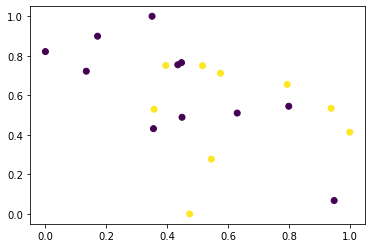

In [135]:
plt.scatter(np.stack(data.input.values)[:,0], np.stack(data.input.values)[:,1], c=-np.stack(data.target.values)>=0)

## data stats

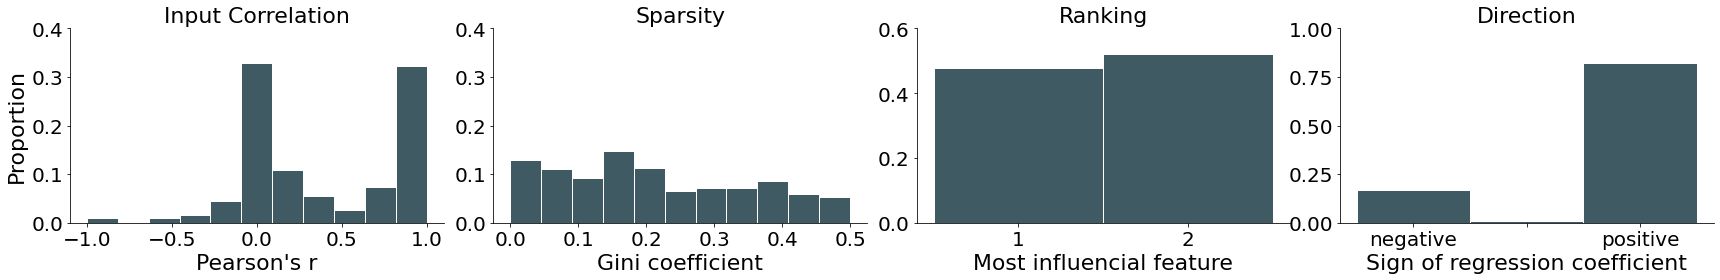

In [14]:
mode=2
dim=2
condition = 'real'
color_stats = '#405A63' 

stats = np.load(
f'{SYS_PATH}/decisionmaking/data/stats/stats_{str(mode)}_{str(dim)}_{condition}.npz', allow_pickle=True)
all_corr, gini_coeff, posterior_logprob, all_accuraries_linear = stats['all_corr'], stats[
'gini_coeff'], stats['posterior_logprob'], stats['all_accuraries_linear']
all_accuraries_polynomial, all_targets_with_norm, all_features_with_norm, sign_coeff, direction_coeff = stats[
'all_accuraries_polynomial'], stats['all_targets_with_norm'], stats['all_features_with_norm'], stats['sign_coeff'], stats['direction_coeff']

gini_coeff = np.array(gini_coeff)
gini_coeff = gini_coeff[~np.isnan(gini_coeff)]
all_corr = np.array(all_corr)
sign_coeff = np.array(sign_coeff)
direction_coeff = np.stack(direction_coeff)

FONTSIZE = 22  # 8
fig, axs = plt.subplots(1, 4,  figsize=(6*4, 4))  # figsize=(6.75, 1.5))
sns.histplot(all_corr.reshape(-1), ax=axs[0], bins=11, binrange=(
        -1., 1.), stat='probability', edgecolor='w', linewidth=1, color=color_stats, alpha=1.)
sns.histplot(gini_coeff, ax=axs[1], bins=11, binrange=(
        0., gini_coeff.max()), stat='probability', edgecolor='w', linewidth=1, color=color_stats, alpha=1.)
sns.histplot(np.argmax(np.abs(direction_coeff), axis=1), ax=axs[2], bins=dim, binrange=(
        -0.5, dim-0.5), stat='probability', edgecolor='w', linewidth=1, color=color_stats, alpha=1.)
sns.histplot(sign_coeff.reshape(-1), ax=axs[3], bins=3, binrange=(
        -1.5, 1.5), stat='probability', edgecolor='w', linewidth=1, color=color_stats, alpha=1.)

axs[0].set_ylim(0, .4)
axs[1].set_ylim(0, .4)
axs[2].set_ylim(0, .6)
axs[3].set_ylim(0, 1.)

# axs[0].set_yticks(np.arange(0.5, 1.05, 0.25))
# axs[1].set_yticks(np.arange(0, 0.45, 0.2))
# axs[2].set_yticks(np.arange(0, 0.4, 0.15))
# axs[3].set_yticks(np.arange(0, 1.05, 0.5))

axs[2].set_xticks(np.arange(0, dim, 1))
axs[2].set_xticklabels([f"{i+1}" for i in range(dim)])
axs[3].set_xticks(np.arange(-1, 2, 1))
axs[3].set_xticklabels(['negative', '', 'positive'])

# set tick size
axs[0].tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
axs[1].tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
axs[2].tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
axs[3].tick_params(axis='both', which='major', labelsize=FONTSIZE-2)

axs[0].set_ylabel('Proportion', fontsize=FONTSIZE)
axs[1].set_ylabel('', fontsize=FONTSIZE)
axs[2].set_ylabel('')
axs[3].set_ylabel('')

axs[0].set_xlabel('Pearson\'s r', fontsize=FONTSIZE)
axs[1].set_xlabel('Gini coefficient', fontsize=FONTSIZE)
axs[2].set_xlabel('Most influencial feature', fontsize=FONTSIZE)
axs[3].set_xlabel('Sign of regression coefficient', fontsize=FONTSIZE)

# set title
axs[0].set_title('Input Correlation', fontsize=FONTSIZE)
axs[1].set_title('Sparsity', fontsize=FONTSIZE)
axs[2].set_title('Ranking', fontsize=FONTSIZE)
axs[3].set_title('Direction', fontsize=FONTSIZE)

plt.tight_layout()
sns.despine()
plt.show()

In [2]:
data = pd.read_csv('/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp3.csv')
data['correct'] = data['choice']==data['target']

In [3]:
data.head()

,Unnamed: 0,participant,task,trial,choice,reward,x0,x1,target,time,tier,correct
0,0,0,0,0,1,1.0,-1.46,-1.73,1,408313.0,0.0,True
1,1,0,0,1,0,-1.0,-0.44,0.16,1,420379.0,0.0,False
2,2,0,0,2,1,1.0,-0.81,0.37,1,431205.0,0.0,True
3,3,0,0,3,0,1.0,1.84,-0.19,0,442959.0,0.0,True
4,4,0,0,4,1,1.0,-1.30,-1.44,1,448754.0,0.0,True


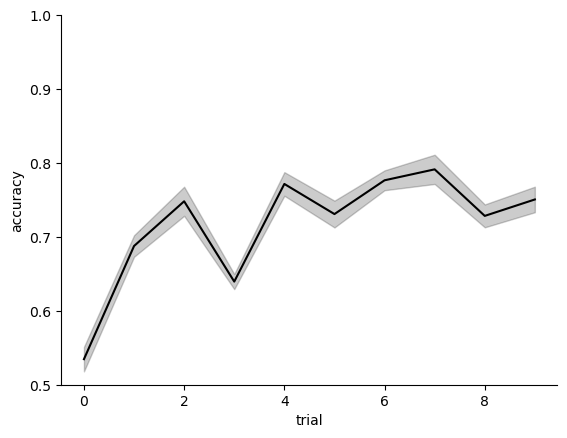

In [4]:
# plot mean accuracy of participants over trials
acc = data.groupby(['participant', 'trial']).correct.mean().reset_index()
sns.lineplot(data=acc, x='trial', y='correct', errorbar="se", color='k')
plt.ylabel('accuracy')
plt.ylim(0.5, 1.) # set y axis limit between 0.5 and 1.
sns.despine()

In [5]:
aa = np.asarray([[0.43333334, 0.6333333 , 0.53333336, 0.6666667 , 0.6333333 ,
        0.73333335, 0.7       , 0.8333333 , 0.8       , 0.8666667 ],
       [0.5       , 0.6333333 , 0.6       , 0.6333333 , 0.8       ,
        0.8       , 0.73333335, 0.8333333 , 0.8       , 0.8       ],
       [0.4       , 0.56666666, 0.6333333 , 0.7       , 0.76666665,
        0.76666665, 0.8666667 , 0.76666665, 0.73333335, 0.76666665],
       [0.46666667, 0.56666666, 0.73333335, 0.7       , 0.73333335,
        0.8       , 0.76666665, 0.8666667 , 0.8666667 , 0.76666665],
       [0.43333334, 0.5       , 0.9       , 0.6666667 , 0.76666665,
        0.73333335, 0.8333333 , 0.8       , 0.8333333 , 0.76666665],
       [0.43333334, 0.56666666, 0.76666665, 0.53333336, 0.76666665,
        0.7       , 0.6666667 , 0.8       , 0.6333333 , 0.76666665],
       [0.46666667, 0.5       , 0.6666667 , 0.6333333 , 0.8333333 ,
        0.76666665, 0.8       , 0.8333333 , 0.73333335, 0.7       ],
       [0.43333334, 0.56666666, 0.73333335, 0.56666666, 0.7       ,
        0.8       , 0.73333335, 0.8       , 0.7       , 0.8666667 ],
       [0.6       , 0.6333333 , 0.8333333 , 0.6       , 0.8       ,
        0.6333333 , 0.7       , 0.6666667 , 0.8       , 0.8666667 ],
       [0.43333334, 0.4       , 0.76666665, 0.6333333 , 0.8333333 ,
        0.6333333 , 0.8333333 , 0.9       , 0.76666665, 0.73333335],
       [0.4       , 0.56666666, 0.8       , 0.6666667 , 0.8       ,
        0.6666667 , 0.7       , 0.8333333 , 0.76666665, 0.8333333 ],
       [0.4       , 0.4       , 0.76666665, 0.6666667 , 0.73333335,
        0.76666665, 0.7       , 0.9       , 0.76666665, 0.6666667 ],
       [0.36666667, 0.7       , 0.73333335, 0.6666667 , 0.6666667 ,
        0.76666665, 0.76666665, 0.8333333 , 0.8       , 0.8       ],
       [0.43333334, 0.6333333 , 0.6666667 , 0.6       , 0.8       ,
        0.76666665, 0.7       , 0.76666665, 0.7       , 0.8333333 ],
       [0.5       , 0.6333333 , 0.7       , 0.6666667 , 0.73333335,
        0.8       , 0.7       , 0.6666667 , 0.6666667 , 0.8       ],
       [0.33333334, 0.5       , 0.6333333 , 0.7       , 0.8333333 ,
        0.6666667 , 0.6       , 0.76666665, 0.8666667 , 0.8       ],
       [0.4       , 0.6666667 , 0.8666667 , 0.53333336, 0.76666665,
        0.6666667 , 0.9       , 0.73333335, 0.6666667 , 0.76666665],
       [0.33333334, 0.53333336, 0.76666665, 0.56666666, 0.8333333 ,
        0.76666665, 0.7       , 0.9       , 0.73333335, 0.7       ],
       [0.53333336, 0.6       , 0.7       , 0.7       , 0.76666665,
        0.6333333 , 0.73333335, 0.93333334, 0.73333335, 0.73333335],
       [0.4       , 0.56666666, 0.8333333 , 0.56666666, 0.73333335,
        0.7       , 0.73333335, 0.73333335, 0.8       , 0.76666665],
       [0.33333334, 0.6333333 , 0.73333335, 0.7       , 0.76666665,
        0.8666667 , 0.56666666, 0.9       , 0.8333333 , 0.76666665],
       [0.4       , 0.6333333 , 0.8       , 0.7       , 0.8333333 ,
        0.6       , 0.7       , 0.8333333 , 0.8666667 , 0.7       ],
       [0.4       , 0.5       , 0.8       , 0.73333335, 0.73333335,
        0.73333335, 0.6666667 , 0.7       , 0.8666667 , 0.8333333 ],
       [0.6       , 0.6333333 , 0.8666667 , 0.6       , 0.76666665,
        0.7       , 0.6333333 , 0.8       , 0.76666665, 0.73333335],
       [0.4       , 0.73333335, 0.73333335, 0.6333333 , 0.73333335,
        0.7       , 0.7       , 0.9       , 0.8666667 , 0.8666667 ],
       [0.4       , 0.7       , 0.76666665, 0.6666667 , 0.76666665,
        0.6666667 , 0.6666667 , 0.76666665, 0.6666667 , 0.73333335],
       [0.33333334, 0.6       , 0.76666665, 0.56666666, 0.8666667 ,
        0.6666667 , 0.8       , 0.9       , 0.8333333 , 0.8       ]])

In [6]:
# NEW ERMI MODEL
aa = np.asarray([[0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667]])

In [7]:
bb = np.asarray([[0.6333333 , 0.6       , 0.73333335, 0.53333336, 0.8666667 ,
        0.73333335, 0.8333333 , 0.8666667 , 0.8333333 , 0.56666666],
       [0.56666666, 0.43333334, 0.7       , 0.73333335, 0.8666667 ,
        0.8       , 0.76666665, 0.93333334, 0.8333333 , 0.43333334],
       [0.53333336, 0.6666667 , 0.6666667 , 0.53333336, 0.76666665,
        0.73333335, 0.76666665, 0.8666667 , 0.9       , 0.6666667 ],
       [0.53333336, 0.5       , 0.6666667 , 0.6666667 , 0.7       ,
        0.6666667 , 0.6333333 , 0.9       , 0.8666667 , 0.6       ],
       [0.56666666, 0.7       , 0.6333333 , 0.7       , 0.8       ,
        0.73333335, 0.8       , 0.9       , 0.8333333 , 0.6333333 ],
       [0.46666667, 0.5       , 0.76666665, 0.6       , 0.8       ,
        0.8333333 , 0.6       , 0.96666664, 0.8       , 0.6333333 ],
       [0.73333335, 0.46666667, 0.7       , 0.6666667 , 0.8333333 ,
        0.8       , 0.76666665, 0.8       , 0.8333333 , 0.73333335],
       [0.56666666, 0.6666667 , 0.56666666, 0.6333333 , 0.8       ,
        0.6666667 , 0.8       , 0.8333333 , 0.8       , 0.6333333 ],
       [0.56666666, 0.6       , 0.73333335, 0.56666666, 0.8666667 ,
        0.7       , 0.8333333 , 0.8       , 0.73333335, 0.6       ],
       [0.4       , 0.7       , 0.7       , 0.56666666, 0.8333333 ,
        0.8666667 , 0.8       , 0.8333333 , 0.93333334, 0.6333333 ],
       [0.4       , 0.6       , 0.7       , 0.6333333 , 0.8333333 ,
        0.76666665, 0.6333333 , 0.8333333 , 0.9       , 0.6333333 ],
       [0.56666666, 0.6333333 , 0.73333335, 0.5       , 0.8       ,
        0.76666665, 0.8333333 , 0.8333333 , 0.8333333 , 0.6666667 ],
       [0.4       , 0.6666667 , 0.6333333 , 0.53333336, 0.9       ,
        0.73333335, 0.76666665, 0.9       , 0.8666667 , 0.73333335],
       [0.46666667, 0.6333333 , 0.73333335, 0.6666667 , 0.8       ,
        0.73333335, 0.8666667 , 0.8666667 , 0.9       , 0.56666666],
       [0.46666667, 0.6333333 , 0.8       , 0.73333335, 0.8333333 ,
        0.6333333 , 0.8333333 , 0.8333333 , 0.8       , 0.6666667 ],
       [0.53333336, 0.56666666, 0.8       , 0.56666666, 0.93333334,
        0.73333335, 0.8       , 0.9       , 0.8666667 , 0.7       ],
       [0.5       , 0.6666667 , 0.76666665, 0.6       , 0.73333335,
        0.7       , 0.8333333 , 0.9       , 0.93333334, 0.6       ],
       [0.56666666, 0.56666666, 0.8       , 0.56666666, 0.8       ,
        0.76666665, 0.8333333 , 0.93333334, 0.96666664, 0.6333333 ],
       [0.6333333 , 0.6333333 , 0.6       , 0.6       , 0.9       ,
        0.8       , 0.8666667 , 0.93333334, 0.8666667 , 0.56666666],
       [0.46666667, 0.7       , 0.73333335, 0.53333336, 0.8333333 ,
        0.6666667 , 0.76666665, 0.76666665, 0.8333333 , 0.56666666],
       [0.56666666, 0.43333334, 0.6       , 0.56666666, 0.8333333 ,
        0.6333333 , 0.8333333 , 0.8333333 , 0.8333333 , 0.6666667 ],
       [0.43333334, 0.6333333 , 0.6333333 , 0.56666666, 0.8666667 ,
        0.8333333 , 0.8666667 , 0.96666664, 0.8       , 0.53333336],
       [0.43333334, 0.56666666, 0.6333333 , 0.7       , 0.8333333 ,
        0.8       , 0.76666665, 0.8666667 , 0.9       , 0.6       ],
       [0.46666667, 0.46666667, 0.73333335, 0.6333333 , 0.8       ,
        0.76666665, 0.8666667 , 0.9       , 0.8666667 , 0.6       ],
       [0.6       , 0.46666667, 0.6666667 , 0.6666667 , 0.73333335,
        0.6666667 , 0.76666665, 0.8333333 , 0.8333333 , 0.6333333 ],
       [0.6333333 , 0.53333336, 0.8333333 , 0.53333336, 0.73333335,
        0.8666667 , 0.8333333 , 0.8       , 0.8       , 0.43333334],
       [0.43333334, 0.6666667 , 0.8       , 0.6333333 , 0.73333335,
        0.8333333 , 0.8       , 0.8666667 , 0.8666667 , 0.7       ]])

In [8]:
bb = np.asarray([[0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333]])

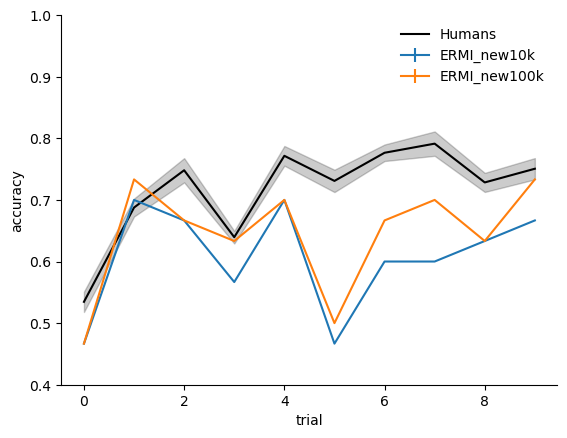

In [10]:
# binomial smapling policy
plt.errorbar(x=np.arange(10), y=aa.mean(0),yerr=aa.std(0)/np.sqrt(30), label='ERMI_new10k')
plt.errorbar(x=np.arange(10), y=bb.mean(0),yerr=bb.std(0)/np.sqrt(30), label='ERMI_new100k')
# plt.plot([0.44444444, 0.59012346, 0.74320988, 0.62592593, 0.74320988,
#        0.72098765, 0.74074074, 0.82222222, 0.71851852, 0.76790123], label='ERMI (100k)') 
sns.lineplot(data=acc, x='trial', y='correct', errorbar="se", color='k', label='Humans')
plt.legend(frameon=False)
plt.ylabel('accuracy')
plt.ylim(0.4, 1.) # set y axis limit between 0.5 and 1.
sns.despine()

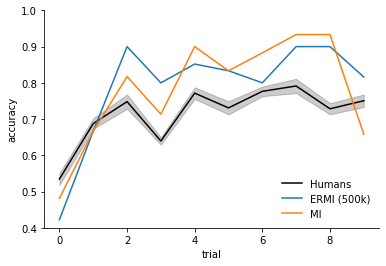

In [21]:
# greedy policy
sns.lineplot(data=acc, x='trial', y='correct', errorbar="se", color='k', label='Humans')
plt.plot([0.42222222, 0.66666667, 0.9       , 0.8       , 0.85185185,
       0.83333333, 0.8       , 0.9       , 0.9       , 0.81604938], label='ERMI (500k)')

plt.plot([0.48148148, 0.66666667, 0.81728395, 0.71358025, 0.9       ,
       0.83333333, 0.88271605, 0.93333333, 0.93333333, 0.65802469], label='MI')
plt.legend(frameon=False)
plt.ylabel('accuracy')
plt.ylim(0.4, 1.) # set y axis limit between 0.5 and 1.
sns.despine()

In [16]:
ermi_modelfits = [
    (169.5673370361328, [0.33255378]),
    (142.01544189453125, [0.71602505]),
    (183.84768676757812, [0.41944356]),
    (166.8855743408203, [0.43992458]),
    (175.94314575195312, [0.30635112]),
    (157.6065673828125, [0.52620444]),
    (176.923095703125, [0.40333852]),
    (166.6994171142578, [0.43336525]),
    (186.2415771484375, [0.30240063]),
    (152.73886108398438, [0.56479406]),
    (151.4681396484375, [0.59552636]),
    (205.68666076660156, [0.04403305]),
    (170.4123077392578, [0.40618964]),
    (181.92994689941406, [0.43657759]),
    (172.97019958496094, [0.33907086]),
    (177.1389617919922, [0.30561235]),
    (169.86874389648438, [0.36272536]),
    (189.55308532714844, [0.27757055]),
    (189.90966796875, [0.25836013]),
    (170.335693359375, [0.56185734]),
    (188.8916778564453, [0.23787275]),
    (162.29110717773438, [0.45405818]),
    (161.36407470703125, [0.42467121]),
    (156.70956420898438, [0.54853487]),
    (193.26243591308594, [0.19274343]),
    (171.58961486816406, [0.4100367]),
    (192.3779296875, [0.21571546])
]
betas = [beta[1] for beta in ermi_modelfits]
nlls_ermi = np.stack([nll[0] for nll in ermi_modelfits])

In [17]:
results_mi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic_soft_sigmoid_differential_evolution.npz')
results_ermi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0._soft_sigmoid_differential_evolution.npz')

In [22]:
results_mi_matchbmi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_pairedTrue_run=0_synthetic_soft_sigmoid_differential_evolution.npz')
results_ermi_matchbmi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes10000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8__soft_sigmoid_differential_evolution.npz')

In [23]:
logprobs_bmi = torch.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs4_bmli.pth')[0]
logprobs_baselines = torch.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs4_fitted.pth')[0]
logprobs_bmi = torch.cat([logprobs_baselines[:, [0]], logprobs_bmi], dim=-1)
best_logprobs, best_index = torch.max(logprobs_bmi, dim=-1)

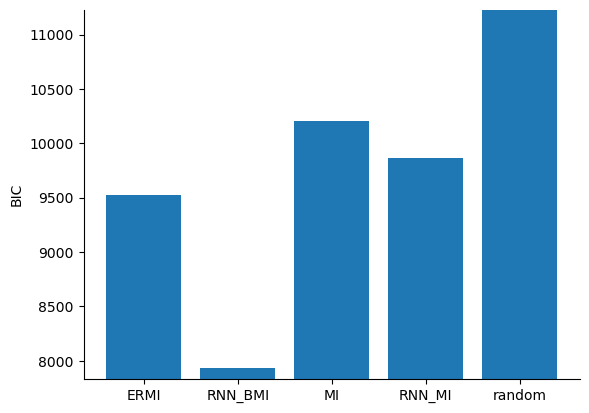

In [24]:
num_participants = 27 #data.participant.nunique()
num_trials = 300
ermi_bic = (2*nlls_ermi+ 1*np.log(num_trials)).sum() 
# ermi_bic = (2*results_ermi['nlls']+ 1*np.log(num_trials)).sum() 
mi_bic = (2*results_mi['nlls'] + 1*np.log(num_trials)).sum()
rnn_mi_bic = (-2*logprobs_bmi[:, 1] + 1*np.log(num_trials)).sum() 
bmi_bic = (-2*best_logprobs + 1*np.log(num_trials)).sum()
random_bic = -2*np.log(0.5)*num_trials*num_participants
bics = [ermi_bic, bmi_bic, mi_bic, rnn_mi_bic, random_bic]
model_names = ['ERMI', 'RNN_BMI', 'MI', 'RNN_MI', 'random']
# plot bar plot comparing the two bics
plt.bar(model_names, bics)
plt.ylim(min(bics)-100, max(bics))
plt.ylabel('BIC')
sns.despine()

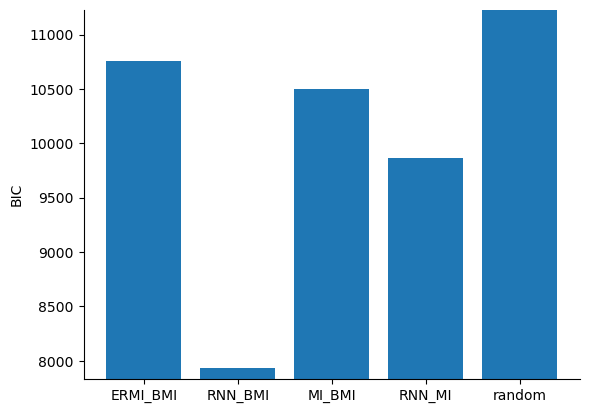

In [25]:
num_participants = 27 #data.participant.nunique()
num_trials = 300
# ermi_bic = (2*nlls_ermi+ 1*np.log(num_trials)).sum() 
ermi_bic = (2*results_ermi_matchbmi['nlls']+ 1*np.log(num_trials)).sum() 
mi_bic = (2*results_mi_matchbmi['nlls'] + 1*np.log(num_trials)).sum()
rnn_mi_bic = (-2*logprobs_bmi[:, 1] + 1*np.log(num_trials)).sum() 
bmi_bic = (-2*best_logprobs + 1*np.log(num_trials)).sum()
random_bic = -2*np.log(0.5)*num_trials*num_participants
bics = [ermi_bic, bmi_bic, mi_bic, rnn_mi_bic, random_bic]
model_names = ['ERMI_BMI', 'RNN_BMI', 'MI_BMI', 'RNN_MI', 'random']
# plot bar plot comparing the two bics
plt.bar(model_names, bics)
plt.ylim(min(bics)-100, max(bics))
plt.ylabel('BIC')
sns.despine()

## order of features returned by f_regression

In [64]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, chi2
X, y = make_regression(
    n_samples=50, n_features=10, n_informative=1, noise=1e-4, random_state=24
)
f_statistic, p_values = f_regression(X, y)
print(f_statistic, p_values)
print(np.argsort(f_statistic)[::-1])

[3.61654401e-02 4.75865040e+00 2.85886447e-01 2.29881296e+00
 8.97270937e-01 1.58268561e+00 4.88196981e-04 8.79972892e-01
 2.59448850e+13 7.92169506e-05] [8.49976241e-001 3.40808997e-002 5.95336973e-001 1.36031474e-001
 3.48259114e-001 2.14459863e-001 9.82463628e-001 3.52905505e-001
 2.96213834e-283 9.92935499e-001]
[8 1 3 5 4 7 2 0 6 9]


In [65]:
features = SelectKBest(f_regression, k=3).fit_transform(X,y)

In [66]:
X[:, [np.argsort(f_statistic)[::-1][:3]]].squeeze()[:10]

array([[-0.38568351,  1.68658289, -0.12981994],
       [-0.45843081, -0.87030545, -0.48737991],
       [ 0.4682458 , -1.52960666,  0.65928705],
       [-0.25946234, -0.46110384, -1.29985501],
       [-0.29875283,  1.63366318, -0.5384125 ],
       [-0.11237268,  0.12929148,  1.15001783],
       [-0.92142334, -1.2344069 ,  1.01914736],
       [-1.11876042,  1.38929256,  0.66948903],
       [ 0.48040324,  0.13248052,  1.22637133],
       [-0.65521245,  0.06896137, -1.15511576]])

In [67]:
features

array([[ 1.68658289e+00, -1.29819937e-01, -3.85683513e-01],
       [-8.70305453e-01, -4.87379905e-01, -4.58430810e-01],
       [-1.52960666e+00,  6.59287051e-01,  4.68245802e-01],
       [-4.61103845e-01, -1.29985501e+00, -2.59462337e-01],
       [ 1.63366318e+00, -5.38412499e-01, -2.98752828e-01],
       [ 1.29291476e-01,  1.15001783e+00, -1.12372680e-01],
       [-1.23440690e+00,  1.01914736e+00, -9.21423336e-01],
       [ 1.38929256e+00,  6.69489033e-01, -1.11876042e+00],
       [ 1.32480516e-01,  1.22637133e+00,  4.80403240e-01],
       [ 6.89613668e-02, -1.15511576e+00, -6.55212453e-01],
       [-1.70552321e+00, -2.80869897e-01,  8.56155074e-01],
       [-1.83243718e-01, -3.44900515e-01,  5.13600166e-01],
       [ 6.95803574e-01,  1.08788959e-01,  1.70097271e+00],
       [-3.65388896e-01, -6.67099896e-02,  9.25284336e-01],
       [ 1.83156926e+00, -2.26076842e+00,  5.74383402e-01],
       [ 1.37330437e+00, -5.76660330e-01,  1.63957789e+00],
       [ 5.72560199e-01, -3.33441386e-01